## PyTorch Tutorial #16 - Tensorboard

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [18]:
# En Tensorboard se puede:

# Tracking and visualizing metrics such as loss an accuracy
# Visualizing the model graph (ops and layers)
# Viewing histograms of weights, biases, or other tensors as they change over time
# Pojecting embeddings to a lower dimensional space
# Displaying images, text and audio data
# Profiling TensorFlow programs
# And much more

In [16]:
from torch.utils.tensorboard import SummaryWriter

In [26]:
writer = SummaryWriter(r'C:\Users\Leandro\runs\runs\mnist2')

### Ejemplo de implementación de Tensorboard

In [27]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [29]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

In [30]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [31]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)


torch.Size([100, 1, 28, 28]) torch.Size([100])


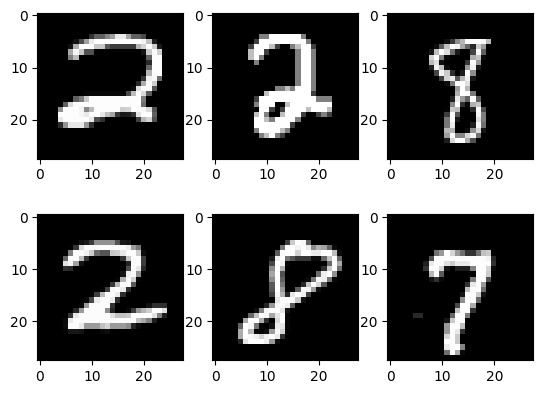

In [32]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap = 'gray')
plt.show()

In [33]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [34]:
model = NeuralNet(input_size, hidden_size, num_classes)
model = model.to(device)

In [35]:
# Creo una grilla de imágenes del tamaño del batch.
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()

In [36]:
# Agrego un grafo de la arquitectura de la red.
writer.add_graph(model, samples.to(device).reshape(-1, 28*28))
writer.close()

In [37]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [43]:
# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1 28, 28
        # 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, steps {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
            # Agrego el gráfico de loss en training y el accuracy.
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0
            
# test
labels1 = []
preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        class_predictions = [F.softmax(output, dim = 0) for output in outputs]

        preds.append(class_predictions)
        labels1.append(predictions)

    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels1 = torch.cat(labels1)

    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')

    # Agrego el gráfico una curva de precision-recall para cada label.
    classes = range(10)
    for i in classes:
        labels_i = labels1 == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step = 0)
        writer.close()

epoch 1 / 2, steps 100 / 600, loss = 0.0207
epoch 1 / 2, steps 200 / 600, loss = 0.0778
epoch 1 / 2, steps 300 / 600, loss = 0.0642
epoch 1 / 2, steps 400 / 600, loss = 0.0155
epoch 1 / 2, steps 500 / 600, loss = 0.0168
epoch 1 / 2, steps 600 / 600, loss = 0.0691
epoch 2 / 2, steps 100 / 600, loss = 0.0351
epoch 2 / 2, steps 200 / 600, loss = 0.0663
epoch 2 / 2, steps 300 / 600, loss = 0.0173
epoch 2 / 2, steps 400 / 600, loss = 0.0552
epoch 2 / 2, steps 500 / 600, loss = 0.0095
epoch 2 / 2, steps 600 / 600, loss = 0.0734
accuracy = 97.81
